pip install seaborn

pip install numpy==1.23.4

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as C
from tensorflow.keras import regularizers
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model,Model
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras import regularizers, constraints, initializers
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

2.6.0


In [2]:
train_path=("/LAB/Brain Tumor/Brain Tumor MRI/train")
test_path=("/LAB/Brain Tumor/Brain Tumor MRI/test")
val_path=("/LAB/Brain Tumor/Brain Tumor MRI/val")
batch_size = 32
img_height = 512
img_width = 512
no_of_clases = 4
clsses_name = ['glioma','meninginoma','notumor','pituitary tumor']
input_shape = (img_height,img_width,1)

datagen = ImageDataGenerator(rescale = 1./255,featurewise_center=True,horizontal_flip=False,vertical_flip = False,validation_split = 0.1,featurewise_std_normalization = True)

train_generator = datagen.flow_from_directory(train_path,target_size=(img_height,img_width),batch_size = batch_size, shuffle =True,class_mode = 'categorical')

validation_generator = datagen.flow_from_directory(val_path,target_size=(img_height,img_width),batch_size = batch_size, shuffle =True,class_mode = 'categorical')

print('train classes')
print(train_generator.class_indices)
print('train labels')
print(train_generator.labels)
print('validation clases')
print(validation_generator.class_indices)
print('validation labels')
print(validation_generator.labels)

Found 5617 images belonging to 4 classes.
Found 701 images belonging to 4 classes.
train classes
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
train labels
[0 0 0 ... 3 3 3]
validation clases
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
validation labels
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [3]:
print(len(train_generator))

176


In [4]:
with tf.device('/GPU:1'):
    pretrained_model = tf.keras.applications.Xception(
                        input_shape=(512, 512, 3),
                        include_top=False,
                        weights='imagenet',
                        pooling='max')

    pretrained_model.trainable = False

2024-03-13 11:01:28.860583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 91 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-03-13 11:01:28.861955: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21789 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [5]:
inputs = pretrained_model.input
outputs = tf.keras.layers.Dense(4, activation='softmax')(pretrained_model.output)

model = tf.keras.Model(inputs, outputs)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [6]:
optimizers = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizers,loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
#callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
with tf.device('/GPU:1'):
    history = model.fit(train_generator,validation_data=validation_generator,epochs=100)

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
2024-03-13 11:01:34.172973: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2024-03-13 11:01:42.969104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


  1/176 [..............................] - ETA: 45:38 - loss: 1.8227 - accuracy: 0.3750

2024-03-13 11:01:49.805534: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


176/176 [==============================] - 175s 911ms/step - loss: 1.0333 - accuracy: 0.5669 - val_loss: 0.7792 - val_accuracy: 0.7019
Epoch 2/100
176/176 [==============================] - 167s 951ms/step - loss: 0.7097 - accuracy: 0.7328 - val_loss: 0.6523 - val_accuracy: 0.7504
Epoch 3/100
176/176 [==============================] - 90s 509ms/step - loss: 0.6055 - accuracy: 0.7769 - val_loss: 0.5494 - val_accuracy: 0.8003
Epoch 4/100
176/176 [==============================] - 160s 912ms/step - loss: 0.5460 - accuracy: 0.7997 - val_loss: 0.5152 - val_accuracy: 0.8046
Epoch 5/100
176/176 [==============================] - 166s 944ms/step - loss: 0.5063 - accuracy: 0.8109 - val_loss: 0.4729 - val_accuracy: 0.8160
Epoch 6/100
176/176 [==============================] - 166s 944ms/step - loss: 0.4753 - accuracy: 0.8255 - val_loss: 0.4504 - val_accuracy: 0.8417
Epoch 7/100
176/176 [==============================] - 166s 941ms/step - loss: 0.4508 - accuracy: 0.8348 - val_loss: 0.4287 - val_a

176/176 [==============================] - 167s 945ms/step - loss: 0.2011 - accuracy: 0.9366 - val_loss: 0.2576 - val_accuracy: 0.9073
Epoch 57/100
176/176 [==============================] - 161s 913ms/step - loss: 0.1995 - accuracy: 0.9370 - val_loss: 0.2569 - val_accuracy: 0.9116
Epoch 58/100
176/176 [==============================] - 164s 930ms/step - loss: 0.1973 - accuracy: 0.9345 - val_loss: 0.2562 - val_accuracy: 0.9101
Epoch 59/100
176/176 [==============================] - 162s 922ms/step - loss: 0.1957 - accuracy: 0.9380 - val_loss: 0.2574 - val_accuracy: 0.9101
Epoch 60/100
176/176 [==============================] - 165s 937ms/step - loss: 0.1946 - accuracy: 0.9382 - val_loss: 0.2574 - val_accuracy: 0.9073
Epoch 61/100
176/176 [==============================] - 164s 930ms/step - loss: 0.1935 - accuracy: 0.9411 - val_loss: 0.2593 - val_accuracy: 0.9073
Epoch 62/100
176/176 [==============================] - 162s 918ms/step - loss: 0.1924 - accuracy: 0.9389 - val_loss: 0.2518 

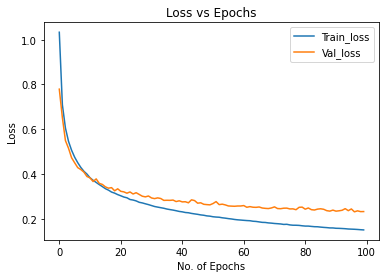

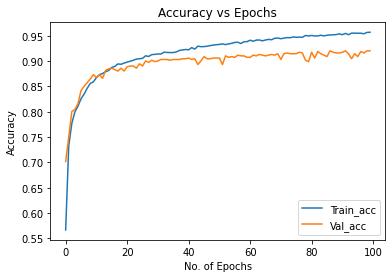

In [8]:
plt.plot(history.history['loss'],label='Train_loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.show()


plt.plot(history.history['accuracy'],label = 'Train_acc')
plt.plot(history.history['val_accuracy'],label = 'Val_acc')
plt.legend()
plt.xlabel('No. of Epochs')
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

In [9]:
test_data = ImageDataGenerator(rescale=1./255)
test_generator = test_data.flow_from_directory(test_path, target_size=(512, 512), batch_size=32, shuffle=False, class_mode="categorical")



Found 705 images belonging to 4 classes.


In [10]:
with tf.device('/GPU:1'):
    predictions = np.argmax(model.predict(test_generator), axis=1)
    matrix = confusion_matrix(test_generator.labels, predictions)
    report= classification_report(test_generator.labels, predictions, target_names=test_generator.class_indices, zero_division=0)

In [11]:
with tf.device('/GPU:1'):
    pred = model.predict(test_generator,verbose=1)
    test_generator_indices = np.argmax(pred,axis=1)

    print(test_generator_indices)

23/23 [==============================] - 18s 788ms/step
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 1 1 1 0 0 0
 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 3 1 1 0 2 2 2 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 3 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 3 1 0 0
 3 1 1 0 1 1 1 1 0 1 3 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 0 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 1 2
 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

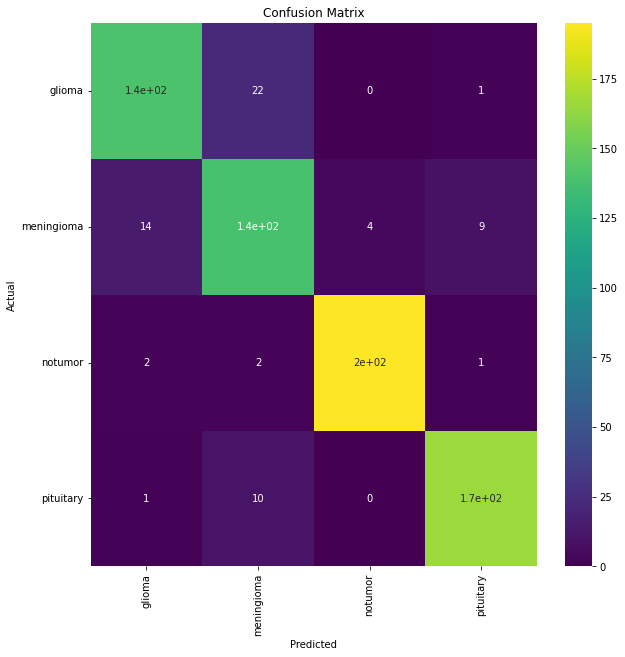

In [12]:
fig = plt.figure(figsize=(10,10))
sns.heatmap(matrix, annot=True, cmap='viridis')
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_generator.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_generator.class_indices, rotation=0)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
fig.savefig("Confusion Matrix",dpi=700)

In [13]:
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.89      0.86      0.87       163
  meningioma       0.80      0.84      0.82       165
     notumor       0.98      0.97      0.98       200
   pituitary       0.94      0.94      0.94       177

    accuracy                           0.91       705
   macro avg       0.90      0.90      0.90       705
weighted avg       0.91      0.91      0.91       705



In [14]:
!nvidia-smi

Wed Mar 13 15:36:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:3B:00.0 Off |                  Off |
| 49%   74C    P2    90W / 230W |  24250MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:AF:00.0 Off |                  Off |
| 52%   